### Description
In this notebook we compare the different measures for adversarial example detection based on previous experiments and evaluate their discriminative power.

In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,roc_auc_score,auc

/home/jungj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
df_pre10 = pd.read_pickle("lid_presoftmax_10")
df_pre100 = pd.read_pickle("lid_presoftmax_100")
df_pre1000 = pd.read_pickle("lid_presoftmax_1000")
df_post10 = pd.read_pickle("lid_postsoftmax_10")

print(len(df_pre100))
df_pre100.head()

49400000


,image,group,batch_size,k,run,lid
0,2446,adv,10000,9000,0,3.476485
1,2446,real,10000,9000,0,2.623526
2,2446,adv,10000,8000,0,4.012423
3,2446,real,10000,8000,0,2.889898
4,2446,adv,10000,7000,0,4.365027


### How good is LID for differnt configurations performing?
We analyze the AUC, similar as in the paper's figure 5
- take samples for the same batch size and same k
- create LID vector and label vector
- calculate AUC value for all different batch sizes and k
- plot AUC value for different batch sizes, k

In [5]:
df = df_pre1000
df.head()

,image,group,batch_size,k,run,lid
0,5912,adv,10000,9000,0,2.941100
1,5912,real,10000,9000,0,2.816226
2,5912,adv,10000,8000,0,3.197393
3,5912,real,10000,8000,0,3.210890
4,5912,adv,10000,7000,0,3.303800


CPU times: user 31.1 s, sys: 27.1 s, total: 58.2 s
Wall time: 39.5 s


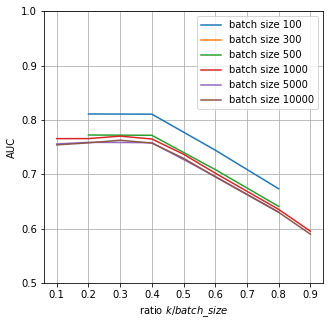

In [10]:
%%time
# calculate AUC for median LID in each configuration (ratio)
batch_sizes = [10000,5000,1000,700,500,300,100] #df.batch_size.unique()
auc_scores = []
for b,batch_size in enumerate(batch_sizes):
    for ratio in np.arange(0.1,1,0.1):
        data = df.query('batch_size == {} & k == {}'.format(batch_size,int(batch_size*ratio)))
        if len(data) == 0:
            continue
        else:
            median = data.groupby(['image','group']).median()
            median.reset_index(inplace=True)  
            labels = np.zeros(len(median))
            labels[median.group == 'adv'] = 1
            auc_scores.append((batch_size,ratio,roc_auc_score(labels,median.lid)))

auc_df = pd.DataFrame(auc_scores, columns=["batch_size","ratio","auc"])

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(0.5,1)

for key, grp in auc_df.groupby(['batch_size']):
    grp.plot(ax=ax,x='ratio',y='auc',label="batch size {}".format(key))
    
plt.grid()
plt.xlabel("ratio $k/batch\_size}$")
plt.ylabel("AUC")

CPU times: user 32 s, sys: 25.4 s, total: 57.4 s
Wall time: 39.7 s


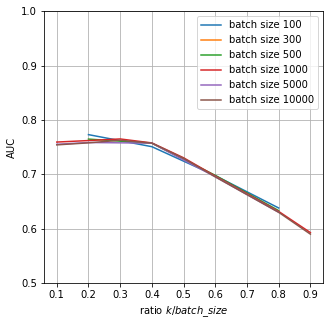

In [9]:
%%time
# calculate AUC for LID in each configuration (ratio)
batch_sizes = [10000,5000,1000,700,500,300,100] #df.batch_size.unique()
auc_scores = []
for b,batch_size in enumerate(batch_sizes):
    for ratio in np.arange(0.1,1,0.1):
        data = df.query('batch_size == {} & k == {}'.format(batch_size,int(batch_size*ratio)))
        if len(data) == 0:
            continue
        else:
            labels = np.zeros(len(data))
            labels[data.group == 'adv'] = 1
            auc_scores.append((batch_size,ratio,roc_auc_score(labels,data.lid)))
auc_df = pd.DataFrame(auc_scores, columns=["batch_size","ratio","auc"])
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(0.5,1)

for key, grp in auc_df.groupby(['batch_size']):
    grp.plot(ax=ax,x='ratio',y='auc',label="batch size {}".format(key))
    
plt.grid(abs)
plt.xlabel("ratio $k/batch\_size}$")
plt.ylabel("AUC")

CPU times: user 34.3 s, sys: 25.3 s, total: 59.5 s
Wall time: 41.8 s


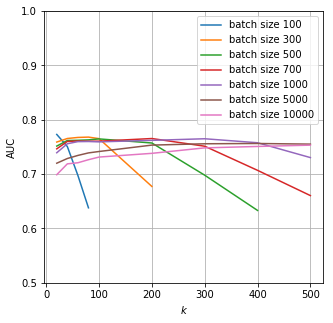

In [18]:
%%time
# calculate AUC for LID in each configuration (k)
batch_sizes = [10000,5000,1000,700,500,300,100] #df.batch_size.unique()
ks = [500,  400,  300,  200,  100,   80,   60,   40,   20]
auc_scores = []
for b,batch_size in enumerate(batch_sizes):
    for _,k in enumerate(ks):
        data = df.query('batch_size == {} & k == {}'.format(batch_size,k))
        if len(data) == 0:
            continue
        else:
            labels = np.zeros(len(data))
            labels[data.group == 'adv'] = 1
            auc_scores.append((batch_size,k,roc_auc_score(labels,data.lid)))
auc_df = pd.DataFrame(auc_scores, columns=["batch_size","k","auc"])
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(0.5,1)

for key, grp in auc_df.groupby(['batch_size']):
    grp.plot(ax=ax,x='k',y='auc',label="batch size {}".format(key))
plt.grid(abs)
plt.xlabel("$k$")
plt.ylabel("AUC")

## Compare LID and MI ROC curves

In [11]:
mi_adv = np.load("mi_adv_1000.npy")
mi_real = np.load("mi_real_1000.npy")
sv_adv = np.load("sv_adv_1000.npy")
sv_real = np.load("sv_real_1000.npy")

In [12]:
batch_size = 100
k = 20
lid_adv_df =  df.query("batch_size == {} & k == {} & group == 'adv'".format(batch_size,k))
lid_real_df =  df.query("batch_size == {} & k == {} & group == 'real'".format(batch_size,k))
lid_adv = lid_adv_df['lid']
lid_real = lid_real_df['lid']

In [13]:
len(lid_adv),len(lid_real),len(mi_adv),len(mi_real)

(100000, 100000, 1000, 1000)

In [14]:
lid_adv_median_df = lid_adv_df.groupby(['image','group']).median()
lid_real_median_df = lid_real_df.groupby(['image','group']).median()
lid_adv_median_df.reset_index(inplace=True)  
lid_real_median_df.reset_index(inplace=True)

In [15]:
lid_adv_median = lid_adv_median_df['lid']
lid_real_median = lid_real_median_df['lid']

/home/jungj/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/jungj/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/jungj/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


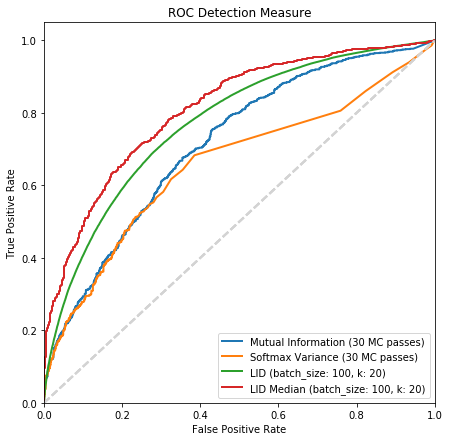

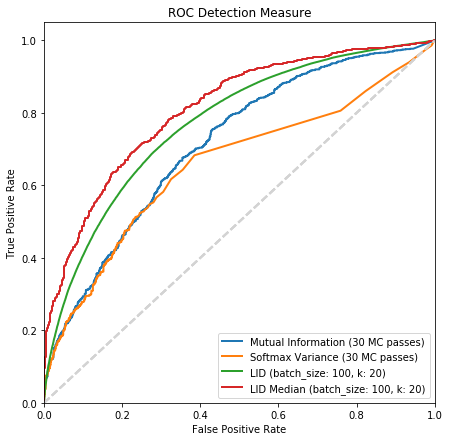

In [16]:
from evaluator import visualization as vis
vis.roc([(mi_adv,mi_real),(sv_adv,sv_real),(lid_adv,lid_real),(lid_adv_median,lid_real_median)],
        ['Mutual Information (30 MC passes)','Softmax Variance (30 MC passes)','LID (batch_size: {}, k: {})'.format(batch_size,k),'LID Median (batch_size: {}, k: {})'.format(batch_size,k)])

In [17]:
from sklearn.metrics import roc_auc_score

labels = np.concatenate((np.ones(1000),np.zeros(1000)))
mi_vector = np.concatenate((mi_adv,mi_real))
print("MI",roc_auc_score(labels,mi_vector))

labels = np.concatenate((np.ones(1000),np.zeros(1000)))
sv_vector = np.concatenate((sv_adv,sv_real))
print("SV",roc_auc_score(labels,sv_vector))

labels = np.concatenate((np.ones(1000),np.zeros(1000)))
lid_median_vector = np.concatenate((lid_adv_median,lid_real_median))
print("LID median",roc_auc_score(labels,lid_median_vector))

labels = np.concatenate((np.ones(100000),np.zeros(100000)))
lid_vector = np.concatenate((lid_adv,lid_real))
print("LID",roc_auc_score(labels,lid_vector))

MI 0.7139305
SV 0.6568475
LID median 0.8108989999999999
LID 0.7729126809
